1.只有周租金，只留数字
2.有周租金、月租金，只取周租金

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('realestate.csv')

In [3]:
df.head()

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,furnished,latitude,longitude
0,435045151,2109/33 MacKenzie St,Melbourne,3000,$560 per week,Apartment,2,1,0,0,N,-37.80768181,144.96683064
1,435045047,2108/11 Rose Lane,Melbourne,3000,$580 per week,Apartment,2,1,0,0,Y,-37.81545214,144.95408105
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,$450 per week,Apartment,1,1,0,0,N,-37.80753655,144.96732789
3,435144711,300/668 Bourke Street,Melbourne,3000,$550 per week,Apartment,2,2,1,0,N,-37.8166019,144.95420038
4,435044255,2108/11 Rose Lane,Melbourne,3000,$600 per week,Apartment,2,1,0,0,Y,-37.81545214,144.95408105


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11143 entries, 0 to 11142
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             11143 non-null  int64 
 1   address        11095 non-null  object
 2   suburb         11143 non-null  object
 3   postcode       11143 non-null  int64 
 4   price          11143 non-null  object
 5   propertyType   11143 non-null  object
 6   bedrooms       11143 non-null  int64 
 7   bathrooms      11143 non-null  int64 
 8   parkingSpaces  11143 non-null  int64 
 9   studies        11143 non-null  int64 
 10  furnished      11143 non-null  object
 11  latitude       11143 non-null  object
 12  longitude      11143 non-null  object
dtypes: int64(6), object(7)
memory usage: 1.1+ MB


In [5]:
df.shape

(11143, 13)

In [6]:
# check 'id' for dublicate data
df.duplicated('id').sum()

10

In [7]:
df.drop_duplicates('id',inplace=True)
df.shape

(11133, 13)

In [8]:
df.isnull().sum()

id                0
address          48
suburb            0
postcode          0
price             0
propertyType      0
bedrooms          0
bathrooms         0
parkingSpaces     0
studies           0
furnished         0
latitude          0
longitude         0
dtype: int64

In [9]:
# address - 48 items missing, remove
df = df.dropna()

In [10]:
df.shape

(11085, 13)

In [11]:
# latitude and longitude have missing values and shown by 'none'; remove
df = df.drop(df[(df['latitude']=='None')|(df['longitude']=='None')].index)
df.shape

(11001, 13)

In [12]:
# process with regular expressions 
def fun(txt):
    txt = txt.lower() #Change Uppercase to Lower case 
    txt = re.sub(' ','',txt) #remove spaces 
    txt = re.sub(',','',txt) #remove comma ','，some numbers like 1,200, the comma needs to be removed for matching
    txt = re.sub('\.(\d+)','',txt) #process price data, remove decimal places - 250.00-->250
    txt = re.sub('\.','',txt) #remove'.'，p.w. also refers to perweek
    res = re.findall('/w|p/?w|week',txt) # extract key words like perweek,/week,week,pw,/pw,p/w...
    
    # no matching string containing key words like perweek,/week... (not containing matching words)
    if len(res)==0: 
        return 0
    
    rent = re.findall('\$(\d+)',txt) #Extract the rental amount, which may contain both weekly and monthly rents, and return a matching string
    
    # if no matching string is returned, then there is no rent data in the certain price; fill it with zeros for now. （not containing rent data不含租金数据）
    if len(rent)==0:
        return 0
    
    # take the minimum value when having both weekly rent and monthly rent
    rent = [int(rent[i]) for i in range(len(rent))]
    return min(rent)

In [13]:
df['price'] = df['price'].apply(fun)

In [14]:
# remove the data whose week rent is lower than $100
df_new = df[df['price']>=100]
df_new['price'].describe()

count    10478.000000
mean       530.038939
std        268.820472
min        140.000000
25%        400.000000
50%        465.000000
75%        590.000000
max       6000.000000
Name: price, dtype: float64

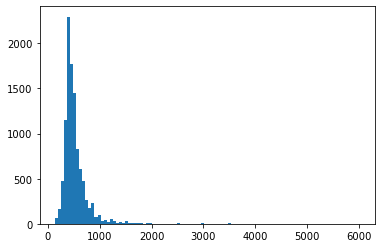

In [15]:
plt.hist(df_new['price'],bins=100)
plt.show()

In [16]:
df_school = pd.read_csv('SchoolLocations2022.csv',encoding='latin-1')
df_school

,Education_Sector,Entity_Type,SCHOOL_NO,School_Name,School_Type,School_Status,Address_Line_1,Address_Line_2,Address_Town,Address_State,...,Postal_Address_Line_1,Postal_Address_Line_2,Postal_Town,Postal_State,Postal_Postcode,Full_Phone_No,LGA_ID,LGA_Name,X,Y
0,Government,1,1,Alberton Primary School,Primary,O,21 Thomson Street,NaN,Alberton,VIC,...,21 Thomson Street,NaN,ALBERTON,VIC,3971,03 5183 2412,681,Wellington (S),146.66660,-38.61771
1,Government,1,3,Allansford and District Primary School,Primary,O,Frank Street,NaN,Allansford,VIC,...,Frank Street,NaN,ALLANSFORD,VIC,3277,03 5565 1382,673,Warrnambool (C),142.59039,-38.38628
2,Government,1,4,Avoca Primary School,Primary,O,118 Barnett Street,NaN,Avoca,VIC,...,P O Box 12,NaN,AVOCA,VIC,3467,03 5465 3176,599,Pyrenees (S),143.47565,-37.08450
3,Government,1,8,Avenel Primary School,Primary,O,40 Anderson Street,NaN,Avenel,VIC,...,40 Anderson Street,NaN,AVENEL,VIC,3664,03 5796 2264,643,Strathbogie (S),145.23472,-36.90137
4,Government,1,12,Warrandyte Primary School,Primary,O,5-11 Forbes Street,NaN,Warrandyte,VIC,...,5-11 Forbes Street,NaN,WARRANDYTE,VIC,3113,03 9844 3537,421,Manningham (C),145.21398,-37.74268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2294,Independent,2,2243,Lysterfield Lake College,Primary,O,20 ABeckett Road,NaN,NARRE WARREN NORTH,VIC,...,20 ABeckett Road,NaN,NARRE WARREN NORTH,VIC,3804,03-,161,Casey (C),145.31604,-37.97748
2295,Independent,2,2244,Plenty River College,Secondary,O,"Unit 5, 9 Danaher Drive",NaN,SOUTH MORANG,VIC,...,"Unit 5, 9 Danaher Drive",NaN,SOUTH MORANG,VIC,3752,03 9435 9060,707,Whittlesea (C),145.08148,-37.64875
2296,Catholic,2,2245,Holy Cross Catholic Primary School,Primary,O,2-14 Carlingford Rd,NaN,MICKLEHAM,VIC,...,2-14 Carlingford Rd,NaN,MICKLEHAM,VIC,3064,03 9216 4200,327,Hume (C),144.90520,-37.53046
2297,Independent,2,2246,Sidrah Gardens School,Primary,O,434-442 Belgrave-Hallam Road,NaN,NARRE WARREN NORTH,VIC,...,434-442 Belgrave-Hallam Road,NaN,NARRE WARREN NORTH,VIC,3804,03-,161,Casey (C),145.31589,-37.97324


In [17]:
df_school['School_Type'].value_counts()

Primary      1577
Secondary     353
Pri/Sec       246
Special       117
Language        4
Camp            2
Name: School_Type, dtype: int64

In [18]:
df_school.duplicated().sum()

0

In [19]:
house_loc = df_new[['latitude', 'longitude']].astype('float64')
sch_loc = df_school[['School_Type','Y','X']]  
sch_loc.isnull().sum()

School_Type    0
Y              1
X              1
dtype: int64

In [20]:
sch_loc = sch_loc.dropna()

In [21]:
sch_loc['School_Type'].value_counts()

Primary      1577
Secondary     352
Pri/Sec       246
Special       117
Language        4
Camp            2
Name: School_Type, dtype: int64

In [22]:
pri_loc = sch_loc[(sch_loc['School_Type']=='Primary')|(sch_loc['School_Type']=='Pri/Sec')][['Y','X']]
sec_loc = sch_loc[(sch_loc['School_Type']=='Secondary')|(sch_loc['School_Type']=='Pri/Sec')][['Y','X']]
other_loc = sch_loc[(sch_loc['School_Type']=='Special')|(sch_loc['School_Type']=='Language')|(sch_loc['School_Type']=='Camp')][['Y','X']]

In [23]:
# pri_min_dist: minimal distance to primary school
pri_dist = cdist(house_loc,pri_loc)
pri_min_dist = pri_dist.min(axis=1)

# sec_min_dist: minimal distance to secondary school
sec_dist = cdist(house_loc,sec_loc)
sec_min_dist = sec_dist.min(axis=1)

# other_min_dist: minimal distance to other school: special,language,camp
other_dist = cdist(house_loc,other_loc)
other_min_dist = other_dist.min(axis=1)

In [24]:
pd.Series(pri_min_dist).describe()

count    10478.000000
mean         0.006918
std          0.025765
min          0.000247
25%          0.003806
50%          0.005951
75%          0.008593
max          2.604375
dtype: float64

In [25]:
pd.Series(sec_min_dist).describe()

count    10478.000000
mean         0.010408
std          0.026611
min          0.000285
25%          0.005304
50%          0.008351
75%          0.012804
max          2.604375
dtype: float64

In [26]:
pd.Series(other_min_dist).describe()

count    10478.000000
mean         0.022753
std          0.040748
min          0.000479
25%          0.009913
50%          0.017205
75%          0.026812
max          3.621274
dtype: float64

In [27]:
df_new['min_pri_distance'] = pd.Series(pri_min_dist)
df_new['min_sec_distance'] = pd.Series(sec_min_dist)
df_new['min_other_distance'] = pd.Series(other_min_dist)

In [28]:
df_new.head()

,id,address,suburb,postcode,price,propertyType,bedrooms,bathrooms,parkingSpaces,studies,furnished,latitude,longitude,min_pri_distance,min_sec_distance,min_other_distance
0,435045151,2109/33 MacKenzie St,Melbourne,3000,560,Apartment,2,1,0,0,N,-37.80768181,144.96683064,0.006237,0.005366,0.012002
1,435045047,2108/11 Rose Lane,Melbourne,3000,580,Apartment,2,1,0,0,Y,-37.81545214,144.95408105,0.013806,0.002584,0.002338
2,435144851,3210/9-23 Mackenzie Street,Melbourne,3000,450,Apartment,1,1,0,0,N,-37.80753655,144.96732789,0.005905,0.005145,0.012461
3,435144711,300/668 Bourke Street,Melbourne,3000,550,Apartment,2,2,1,0,N,-37.8166019,144.95420038,0.012767,0.003718,0.001951
4,435044255,2108/11 Rose Lane,Melbourne,3000,600,Apartment,2,1,0,0,Y,-37.81545214,144.95408105,0.013806,0.002584,0.002338


In [29]:
df_new.to_csv('new_realestate.csv')